## Customer Churn ##

> "Churn Rate" is a business term describing the rate at which customers leave or cease paying for a product or service. It's a critical figure in many businesses, as it's often the case that acquiring new customers is a lot more costly than retaining existing ones (in some cases, 5 to 20 times more expensive). 

> Understanding what keeps customers engaged, therefore, is incredibly valuable, as it is a logical foundation from which to develop retention strategies and roll out operational practices aimed to keep customers from walking out the door. 

> Predicting churn is particularly important for businesses w/ subscription models such as cell phone, cable, or merchant credit card processing plans. 

# The Dataset # 

The data set we'll be using is a longstanding telecom customer data set.

The data is straightforward. Each row represents a subscribing telephone customer. Each column contains customer attributes such as phone number, call minutes used during different times of day, charges incurred for services, lifetime account duration, and whether or not the customer is still a customer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
%matplotlib inline 

In [2]:
churn_df = pd.read_csv('churn.csv')
col_names = churn_df.columns.tolist()

print ("Column names:")
print (col_names)   

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']


In [4]:
churn_df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


** Extract sample dataset **

In [3]:
to_show = col_names[:6] + col_names[-6:]

print ("\nSample data:")
churn_df[to_show].head(6)   


Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.


Let's keep the statistical model pretty simple so the feature space is almost unchanged from what you see above.
We will need to simply drops irrelevant columns and converts strings to boolean values (since models don't handle "yes" and "no" very well). The rest of the numeric columns are left untouched.

In [5]:
# Isolate target data, convert True/False to 1/0 respectively.
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

In [8]:
# Drop the irrelevant columns
to_drop = ['State','Area Code','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1)

In [9]:
# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'
churn_feat_space[yes_no_cols].head()

,Int'l Plan,VMail Plan
0,False,True
1,False,True
2,False,False
3,True,False
4,True,False


In [10]:
# Pull out features for future use
features = churn_feat_space.columns
features

Index(['Account Length', 'Int'l Plan', 'VMail Plan', 'VMail Message',
       'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls',
       'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins',
       'Intl Calls', 'Intl Charge', 'CustServ Calls'],
      dtype='object')

In [11]:
X = churn_feat_space.as_matrix().astype(np.float)
X

array([[ 128.  ,    0.  ,    1.  , ...,    3.  ,    2.7 ,    1.  ],
       [ 107.  ,    0.  ,    1.  , ...,    3.  ,    3.7 ,    1.  ],
       [ 137.  ,    0.  ,    0.  , ...,    5.  ,    3.29,    0.  ],
       ..., 
       [  28.  ,    0.  ,    0.  , ...,    6.  ,    3.81,    2.  ],
       [ 184.  ,    1.  ,    0.  , ...,   10.  ,    1.35,    2.  ],
       [  74.  ,    0.  ,    1.  , ...,    4.  ,    3.7 ,    0.  ]])

One slight side note. Many predictors care about the relative size of different features even though those scales might be arbitrary. For instance: the number of points a basketball team scores per game will naturally be a couple orders of magnitude larger than their win percentage. But this doesn't mean that the latter is 100 times less signifigant. `StandardScaler` fixes this by normalizing each feature to a range of around 1.0 to -1.0 thereby preventing models from misbehaving. Well, at least for that reason.

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 0.67648946, -0.32758048,  1.6170861 , ..., -0.60119509,
        -0.0856905 , -0.42793202],
       [ 0.14906505, -0.32758048,  1.6170861 , ..., -0.60119509,
         1.2411686 , -0.42793202],
       [ 0.9025285 , -0.32758048, -0.61839626, ...,  0.21153386,
         0.69715637, -1.1882185 ],
       ..., 
       [-1.83505538, -0.32758048, -0.61839626, ...,  0.61789834,
         1.3871231 ,  0.33235445],
       [ 2.08295458,  3.05268496, -0.61839626, ...,  2.24335625,
        -1.87695028,  0.33235445],
       [-0.67974475, -0.32758048,  1.6170861 , ..., -0.19483061,
         1.2411686 , -1.1882185 ]])

In [13]:
print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))  

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


Great, I now have a feature space `X` and a set of target values `y`. On to the predictions!

## How good is your model? ##

Cross validation attempts to avoid overfitting (training on and predicting the same datapoint) while still producing a prediction for each observation dataset. When done correctly, every observation will have a 'fair' corresponding prediction.

In [14]:
from sklearn.cross_validation import KFold

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=3,shuffle=True)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

/home/iss-user/anaconda3/envs/iss-env-py3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's compare 4 fairly unique algorithms: logistic regression, support vector machines, random forest, and k-nearest-neighbors. 

Nothing fancy here, just passing each to cross validation and determining how often the classifier predicted the correct class.

In [15]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import average_precision_score

def accuracy(y_true,y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print ("Logistic Regression     Model accuracy : %.3f" % accuracy(y, run_cv(X,y,LR)))
print ("Support vector machine  Model accuracy : %.3f" % accuracy(y, run_cv(X,y,SVC)))
print ("Random forest           Model accuracy : %.3f" % accuracy(y, run_cv(X,y,RF)))
print ("K-nearest-neighbors     Model accuracy : %.3f" % accuracy(y, run_cv(X,y,KNN)))
print ("Gradient Boosting       Model accuracy : %.3f" % accuracy(y, run_cv(X,y,GBC)))


Logistic Regression     Model accuracy : 0.861
Support vector machine  Model accuracy : 0.915
Random forest           Model accuracy : 0.940
K-nearest-neighbors     Model accuracy : 0.889
Gradient Boosting       Model accuracy : 0.946


Ensemble Classifier seems to be the best here.

## Precision and recall ##

Measurements aren't golden formulas which always spit out high numbers for good models and low numbers for bad ones. Inherently they convey something sentiment about a model's performance, and it's the job of the human designer to determine each number's validity. The problem with accuracy is that outcomes aren't necessarily equal. If my classifier predicted a customer would churn and they didn't, that's not the best but it's forgivable. However, if my classifier predicted a customer would return, I didn't act, and then they churned... that's really bad.

We'll be using another built in `scikit-learn` function to construction a confusion matrix. A confusion matrix is a way of visualizing predictions made by a classifier and is just a table showing the distribution of predictions for a specific class. The x-axis indicates the true class of each observation (if a customer churned or not) while the y-axis corresponds to the class predicted by the model (if my classifier said a customer would churned or not).

## Confusion matrix and confusion tables: 
The columns represent the actual class and the rows represent the predicted class. Lets evaluate performance: 

|      | condition True | condition false|
|------|----------------|---------------|
|prediction true|True Positive|False positive|
|Prediction False|False Negative|True Negative|

Sensitivity, Recall or True Positive Rate quantify the models ability to predict our positive classes. 

$$TPR = \frac{ TP}{TP + FN}$$ 

Specificity or True Negative Rate quantify the models ability to predict our Negative classes. 

$$TNR = \frac{ TN}{FP + TN}$$ 

### Example:

|      | Spam | Ham|
|------|----------------|---------------|
|prediction Spam|100|50|
|Prediction Ham|75|900|

$$TPR = \frac{100}{100 + 75} = 57.14 \%   Sensitive $$

$$TNR = \frac{ 900}{50 + 900} = 94.73 \% Specific $$



[[2774   76]
 [ 382  101]]


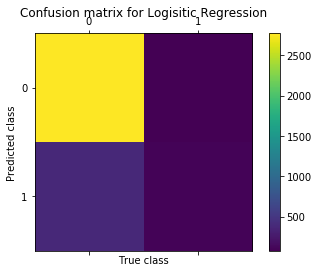

[[2824   26]
 [ 253  230]]


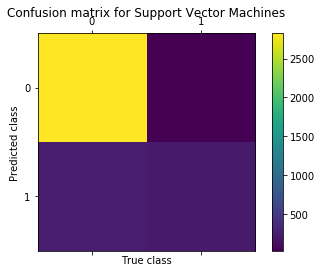

[[2816   34]
 [ 151  332]]


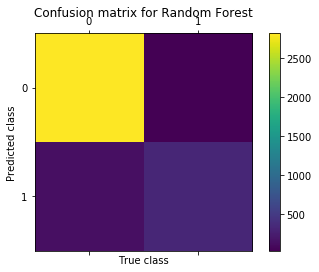

[[2811   39]
 [ 326  157]]


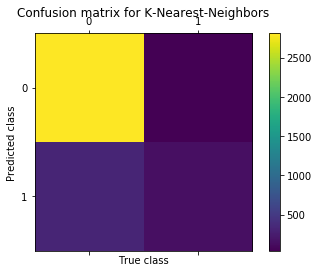

[[2811   39]
 [ 121  362]]


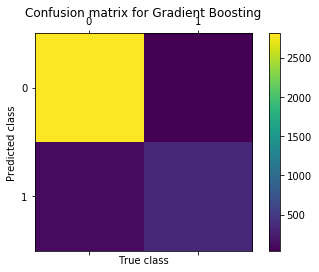

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('True class')
        plt.ylabel('Predicted class')
        plt.show()
    
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Logisitic Regression", confusion_matrix(y,run_cv(X,y,LR)) ),
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
    ( "Gradient Boosting", confusion_matrix(y,run_cv(X,y,GBC)) )
]

# Pyplot code not included to reduce clutter
# from churn_display import draw_confusion_matrices
%matplotlib inline

draw_confusion_matrices(confusion_matrices,class_names)

An important question to ask might be, When an individual churns, how often does my classifier predict that correctly? This measurement is called "recall" and a quick look at these diagrams can demonstrate that random forest is clearly best for this criteria. Out of all the churn cases (outcome "1") random forest correctly retrieved 330 out of 482. This translates to a churn "recall" of about 64% (310/483≈2/3), far better than support vector machines (≈50%) or k-nearest-neighbors (≈35%).

Another question of importance is "precision" or, When a classifier predicts an individual will churn, how often does that individual actually churn? The differences in semantic are small from the previous question, but it makes quite a different. Random forest again out preforms the other two at about 92% precision (310 out of 338) with support vector machines a little behind at about 87% (235 out of 269). K-nearest-neighbors lags at about 80%.

While, just like accuracy, precision and recall still rank random forest above SVC and KNN, this won't always be true. When different measurements do return a different pecking order, understanding the values and trade-offs of each rating should effect how you proceed.

## ROC Plots & AUC

Simply put, the area under the curve (AUC) of a receiver operating characteristic (ROC) curve is a way to reduce ROC performance to a single value representing expected performance.

To explain with a little more detail, a ROC curve plots the true positives (sensitivity) vs. false positives (1 − specificity), for a binary classifier system as its discrimination threshold is varied. Since a random method describes a horizontal curve through the unit interval, it has an AUC of .5. Minimally, classifiers should perform better than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is larger), they have better expected performance. 

Logisitic Regression:


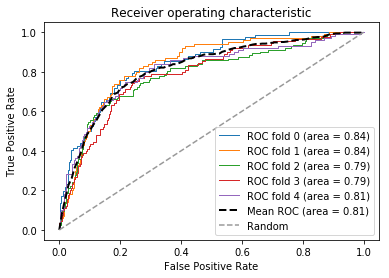

Support vector machines:


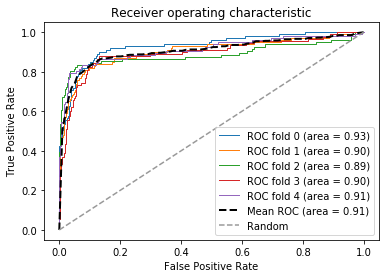

Random forests:


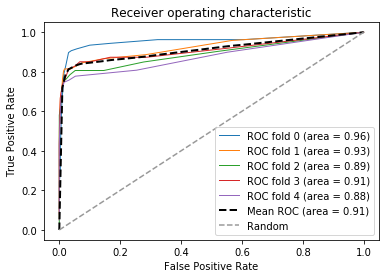

K-nearest-neighbors:


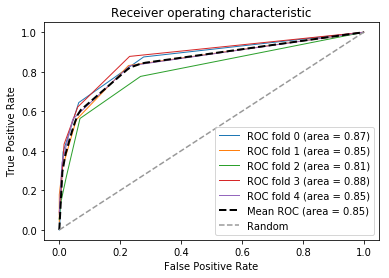

Gradient Boosting Classifier:


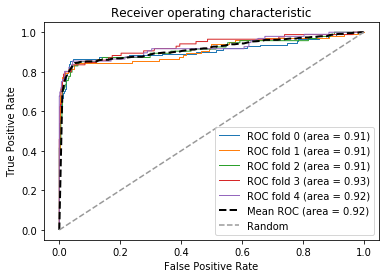

In [17]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
      
print ("Logisitic Regression:")
plot_roc(X,y,LR)

print ("Support vector machines:")
plot_roc(X,y,SVC,probability=True)

print ("Random forests:")
plot_roc(X,y,RF,n_estimators=18)

print ("K-nearest-neighbors:")
plot_roc(X,y,KNN)

print ("Gradient Boosting Classifier:")
plot_roc(X,y,GBC)

## Feature Importance

Now that we understand the accuracy of each individual model for our particular dataset, let's dive a little deeper to get a better understanding of what features or behaviours are causing our customers to churn. In the next section, we will be using a `RandomForestClassifer` to build an ensemble of decision trees to predict whether a customer will churn or not churn. One of the first steps in building a decision tree to calculating the _information gain_ associated with splitting on a particular feature. (More on this later.)

Let's look at the Top 10 features in our dataset that contribute to customer churn:

Feature ranking:
1. Account Length (0.148781)
2. Int'l Plan (0.137040)
3. VMail Plan (0.076932)
4. VMail Message (0.063346)
5. Day Mins (0.059876)
6. Day Calls (0.039575)
7. Day Charge (0.033568)
8. Eve Mins (0.030917)
9. Eve Calls (0.026179)
10. Eve Charge (0.020406)


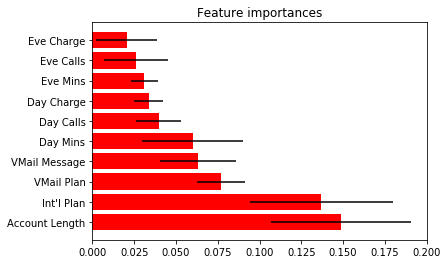

In [18]:
train_index,test_index = train_test_split(churn_df.index)

forest = RF()
forest_fit = forest.fit(X[train_index], y[train_index])
forest_predictions = forest_fit.predict(X[test_index])

importances = forest_fit.feature_importances_[:10]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
#import pylab as pl
plt.figure()
plt.title("Feature importances")
plt.barh(range(10), importances[indices], xerr=std[indices], color="r", align="center")
# plt.xticks(range(10), indices)
plt.yticks(range(10), features)
# plt.xlim([-1, 10])
plt.show()

## Thinking in Probabilities

Decision making often favors probability over simple classifications. There's plainly more information in statements like "there's a 20% chance of rain tomorrow" and "about 55% of test takers pass the California bar exam" than just saying "it shouldn't rain tomorrow" or "you'll probably pass." Probability predictions for churn also allow us to gauge a customers expected value, and their expected loss. Who do you want to reach out to first, the client with a 80% churn risk who pays 20,000 annually, or the client who's worth 100,000 a year with a 40% risk? How much should you spend on each client?

Being able to ask that question requires producing predictions a little differently. However, `scikit-learn` makes moving to probabilities easy; my three models have `predict_proba()` built right into their class objects. This is the same cross validation code with only a few lines changed.

In [19]:
def run_prob_cv(X, y, clf_class, roc=False, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

## How good is good?

Determining how good a predictor which gives probabilities rather than classes is a bit more difficult. If I predict there's a 20% likelihood of rain tomorrow I don't get to live out all the possible outcomes of the universe. It either rains or it doesn't.

What helps is that the predictors aren't making one prediction, they're making 3000+. So for every time I predict an event to occur 20% of the time I can see how often those events actually happen. Here's we'll use `pandas` to help me compare the predictions made by random forest against the actual outcomes.

In [20]:
import warnings
warnings.filterwarnings('ignore')

# Use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_prob_cv(X, y, RF, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)
counts[:]

0.0    1770
0.1     697
0.2     258
0.3     119
0.9      89
0.4      78
0.8      71
1.0      69
0.6      67
0.7      64
0.5      51
dtype: int64

In [18]:
from collections import defaultdict
true_prob = defaultdict(float)

# calculate true probabilities
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.0,1795,0.028412
1,0.1,685,0.020438
2,0.2,258,0.058140
3,0.3,99,0.171717
4,0.4,82,0.317073
5,0.5,58,0.465517
6,0.6,57,0.789474
7,0.7,82,0.914634
8,0.8,80,0.987500
9,0.9,74,0.959459


We can see that random forests predicted that 76 individuals would have a 0.9 probability of churn and in actuality that group had a ~0.98 rate.

Credits: featured on the [yhat blog](http://blog.yhathq.com/posts/predicting-customer-churn-with-sklearn.html)